In [1]:

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [3]:
mpl.rcParams['pdf.fonttype'] = 42

# import

In [4]:
dataOp425_AB32=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [6]:
dataOp621_AB32=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-21\1'))
dataOp729_AB32=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-07-29\1'))

In [7]:
dataOp622_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))
dataOp709_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-09\1'))
dataOp718_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-18\1'))

In [8]:
dataOp820_AL34 = wfOpto(Path(r'Y:\Subjects\AL_0034\2024-08-20\1'))
dataOp827_AL34 = wfOpto(Path(r'Y:\Subjects\AL_0034\2024-08-27\1'))
# dataOp903_AL34 = wfOpto(Path(r'Y:\Subjects\AL_0034\2024-09-03\1'))  

MemoryError: Unable to allocate 2.34 GiB for an array with shape (627200000,) and data type float32

In [4]:
dataSt725=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-25\1'))

In [5]:
dataSt816=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-16\1'))

In [6]:
dataSt822=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-22\1'))

In [7]:
dataSt729=wfOpto(Path(r'Y:\Subjects\AL_0034\2024-07-29\1'))
dataSt826=wfOpto(Path(r'Y:\Subjects\AL_0034\2024-08-26\1'))
dataSt902=wfOpto(Path(r'Y:\Subjects\AL_0034\2024-09-02\1'))

In [28]:
dataSt624 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-24\1'))

# a

0
1
2


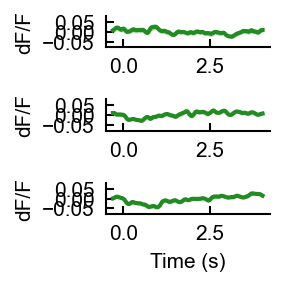

In [57]:
data=dataSt624
pow=0.7;start=-.3;end=4
n_samples=round((end-start)*35)
y=370;x=190;width=50
ylim=[-0.08,0.08];anchor=(1,1.2)

lens =[0.02,0.5,1]
power = np.argwhere(data.laserPowers == pow).ravel()
colors=plt.cm.Greens(np.linspace(.3,1,3))
timestamps=np.linspace(start,end,n_samples)
pxLens=[]
sems=[]

meanimg = data.meanImage.reshape(560,560,-1)
avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

for iL, len in enumerate(lens):
    lenTrs = np.argwhere(data.pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,power)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = videoROI_avg/avg
        trial_activity.append(dff)
    sems.append(scipy.stats.sem(trial_activity,axis=0))
    pxLens.append(np.mean(trial_activity,axis=0))

f = plt.figure(figsize=(2,2))
gs=mpl.gridspec.GridSpec(3,1)

for iL,len in enumerate(pxLens):
    print(iL)
    ax = plt.subplot(gs[iL])
    plt.plot(timestamps,len,color='forestgreen',lw=2)
    plt.fill_between(timestamps, \
        len-sems[iL],\
        len+sems[iL], color='forestgreen',label='_nolegend_',alpha=.3,linewidth=0)
    # plt.xlabel('Time (s)')
    plt.ylabel('dF/F')
    plt.ylim(ylim)
ax = plt.subplot(gs[2])
plt.xlabel('Time (s)')
f.tight_layout()
f.savefig('paperposterfigs/step_2x2.pdf',dpi=300)

# b

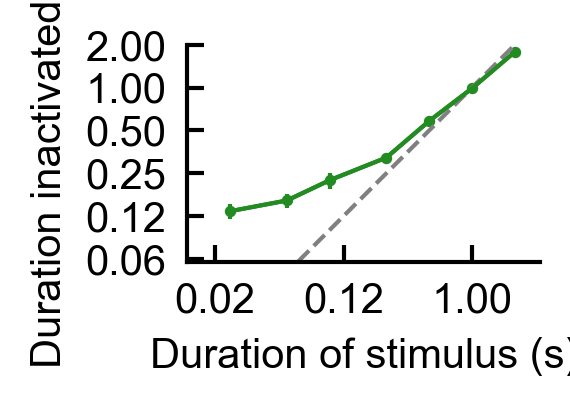

In [9]:
# def belowThresholdTime(ax,data,power=1.7,start=-.3,end=4,y=400,x=150,width=50):

width=50
start=-0.3;end=4
power=1.7
# meanimg = data.meanImage.reshape(560,560,-1)
n_samples=round((start*-1 + end)*35)

#checkers
thresholds=[]
durations=[]
sems=[]

dataList=[dataSt725,dataSt816,dataSt822,
          dataSt729,dataSt826,dataSt902]
pixels=[(400,350),(400,170),(400,170),
        (400,170),
        (400,170),(400,170),(400,170)]
allDurations=[]
for iD, data in enumerate(dataList):
    lens = np.unique(data.pulseLengths).ravel()
    pws = np.argwhere(data.laserPowers==power).ravel()

    #my indices 
    meanimg = data.meanImage.reshape(560, 560, -1)
    y,x=pixels[iD]
    avg = meanimg[(y - width):(y + width), (x - width):(x + width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    allLens=[]
    for iL,len in enumerate(lens):
        #get our trial activity for both baseline period and stim period 
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,pws)
        if theseTrs.size==0:
            continue
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        trial_activity=np.array(trial_activity)

        #get my threshold
        baselines = trial_activity[:,:10]
        std = np.std(baselines)
        threshold = np.mean(baselines) - 2*std
        thresholds.append(threshold)

        #get the time below threshold
        durations_condition=[]
        for activity in trial_activity:
            timeBelow = [i<threshold for i in activity]
            intsBelow = activity[timeBelow]
            durations_condition.append(intsBelow.shape[0]/35) #shape gets the length, 35 to convert to seconds', should be length 35 
        allLens.append(durations_condition[:30]) #should be 7 sessions x 7 seven lengths per session x 35 durations per length 
    allDurations.append(allLens)

allDurations = np.array(allDurations)
for iL,len in enumerate(lens):
    sems.append(scipy.stats.sem(allDurations[:,iL,:].flatten()))
    durations.append(np.mean(allDurations[:,iL,:].flatten()))

fig,ax = plt.subplots(figsize=(2,3),dpi=300)

color='forestgreen'
plt.plot(lens,durations,color=color)
plt.errorbar(lens,durations,sems,color=color)
plt.scatter(lens,durations,color=color,s=3)
plt.xlabel('Duration of stimulus (s)')
plt.ylabel('Duration inactivated (s)')
plt.axline((0.5,0.5),slope=1,color='grey',linestyle='--')
plt.xscale('log',base=2)
plt.yscale('log',base=2)

x_labels = [0.025, 0.05, 0.1, 0.25, 0.5, 1, 2]
y_labels = [i**2 for i in range(1,8)]
current_x_ticks = ax.get_xticks()
current_y_ticks = ax.get_yticks()

# Convert tick positions to labels
x_labels = [f'{tick:.2f}' for tick in current_x_ticks]
y_labels = [f'{tick:.2f}' for tick in current_y_ticks]

# Set custom tick labels
ax.set_xticks(current_x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(current_y_ticks)
ax.set_yticklabels(y_labels)
plt.xlim([0.01,3])
plt.ylim([0.06,2])
ax.set_aspect('equal','box')
fig.savefig('paperposterfigs/fig2b_2x3.pdf',dpi=300)

In [10]:
np.save('stimulus_durations.npy',lens)
np.save('inactivated_durations.npy',durations)

In [13]:
np.save('inactivated_dur_notavgd.npy',allDurations)

# d

In [79]:
-.3*35

-10.5

In [67]:
# def spatThreshold(ax,data,galvoX=0,galvoY=3.3,start=-0.3,end=0.15,color='black',alpha=1):
start=-.3
end=.15
n_samples = round(((start*-1) + end)*35)
powers=[0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2]
# dataList=[dataOp425_AB32,dataOp621_AB32,dataOp729_AB32]
# galvoXList=[0,0,0]
# galvoYList=[3.3,4,4]
dataList=[dataOp425_AB32]
galvoXList=[0]
galvoYList=[3.3]
sems=[]
allsessions=[]
thresholds=[]

mean_ims = []
for iD, data in enumerate(dataList):
    galvoXTrs = np.argwhere(data.galvoX == galvoXList[iD]).ravel()
    galvoYTrs = np.argwhere(data.galvoY == galvoYList[iD]).ravel()
    loc = np.intersect1d(galvoXTrs, galvoYTrs)
    meanimg_full = data.meanImage.reshape(560*560, -1)
    pows_collect=[]
    for i,pow in enumerate(powers):

        #get our trial activity for both baseline period and stim period 
        powTrs = np.argwhere(data.laserPowers == pow).ravel()
        theseTrs=np.intersect1d(powTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, .15+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        vids_time=[]
        vids_notime=[]
        #go thru each trial to get the activity
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat @ wf.T
            dff = mov/meanimg_full

            #take out time dimension
            dff_notime = np.mean(dff[:,10:],axis=1)

            vids_time.append(dff)
            vids_notime.append(dff_notime)
        vids_time = np.array(vids_time)
        vids_notime = np.array(vids_notime)

        #get my threshold
        # vids_time_avg = np.mean(vids_time,axis=0)
        baselines = vids_time[:,:,:10] # 40 trs, 560*560 pixels, 10 frames
        std = np.std(baselines)
        threshold = np.mean(baselines) - 2*std
        thresholds.append(threshold)

        mean_ims.append(np.mean(vids_notime,axis=0))

        # get space below threshold
        # space_condition=[]
        # for vid in vids_notime:
        #     spacebelow = [x for x in vid if x <= threshold]
        #     space_condition.append(np.size(spacebelow)/(vid.shape[0]))
        # pows_collect.append(space_condition)

        # #get space below threshold for mean image
        # space_condition=[]
        # mean_vid = np.mean(vids_notime,axis=0)
        # spacebelow = [x for x in mean_vid if x <= threshold]
        # space_condition.append(np.size(spacebelow)/(mean_vid.shape[0]))
        # print(space_condition)
    # allsessions.append(pows_collect) # append an array 11 powers x 45 or whatever trials 



In [81]:
galvoXTrs = np.argwhere(data.galvoX == galvoXList[iD]).ravel()
galvoYTrs = np.argwhere(data.galvoY == galvoYList[iD]).ravel()
loc = np.intersect1d(galvoXTrs, galvoYTrs)
meanimg_full = data.meanImage.reshape(560*560, -1)
pows_collect=[]
for i,pow in enumerate(powers):

    #get our trial activity for both baseline period and stim period 
    powTrs = np.argwhere(data.laserPowers == pow).ravel()
    theseTrs=np.intersect1d(powTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, .15+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    vids_time=[]
    vids_notime=[]
    #go thru each trial to get the activity
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat @ wf.T
        dff = mov/meanimg_full

        #take out time dimension
        dff_notime = np.mean(dff[:,10:],axis=1)
        vids_notime.append(dff_notime)
    pows_collect.append(np.mean(vids_notime,axis=0))

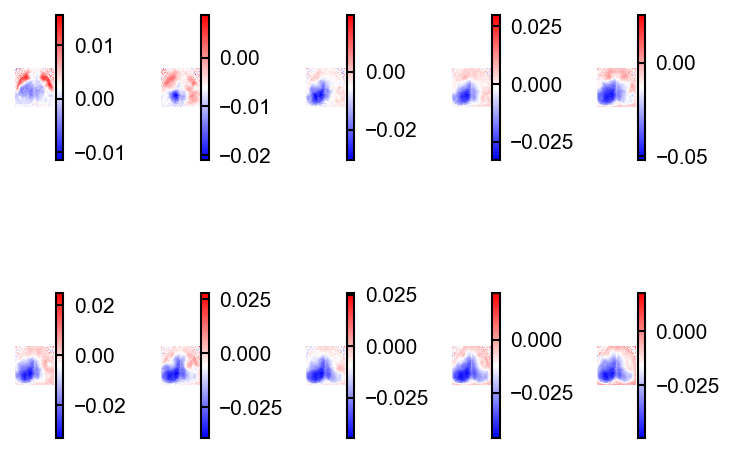

In [82]:
f=plt.figure(figsize=(5,5))
gs = mpl.gridspec.GridSpec(2,5)
for i in range(10):
    ax = plt.subplot(gs[i])
    plt.imshow(pows_collect[i].reshape(560,560),cmap='bwr')
    plt.colorbar()
    plt.axis('off')
    # plt.savefig(f'paperposterfigs/meanimg_{i}.pdf',dpi=300)

In [30]:
mean_ims = np.array(mean_ims)
# mean_ims.shape

In [31]:
mean_ims = mean_ims.reshape(10,560,560)

In [19]:
allsessions_mod=[]
for session in allsessions:
    print(len(session))
    for power in session:
        power = power[:40]
        allsessions_mod.append(power)

10
40
40
40
40
40
40
40
40
40
40
10
45
45
45
45
45
45
45
45
45
45
10
65
45
45
45
45
65
45
45
65
45


In [21]:
allsessions_mod = np.array(allsessions_mod).reshape(3,10,40)

ValueError: 'yerr' (shape: (0,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (10, 1))

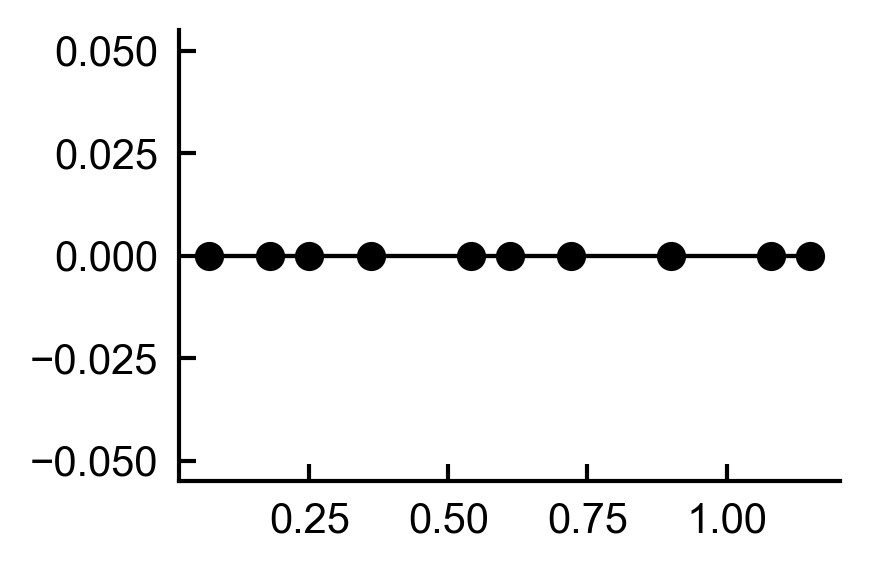

In [18]:
# allsessions = np.array(allsessions) # 3 sessions x 11 powers x 45 trials
fig = plt.figure(figsize=(3,2),dpi=300)

# sems=[]
# spaceinhibs=[]
# for iP,pow in enumerate(powers):
#     sems.append(scipy.stats.sem(allsessions_mod[:,iP,:40].flatten()))
#     spaceinhibs.append(np.mean(allsessions_mod[:,iP,:40].flatten()))

powerscorr = [round(i/2.777777778,2) for i in powers]
plt.plot(powerscorr,allsessions[0],color='black')
plt.scatter(powerscorr,allsessions[0],color='black')
plt.errorbar(powerscorr,allsessions[0],sems,color='black')
plt.xlabel('Laser power (mW)')
plt.ylabel('Proportion of brain inactivated')
fig.tight_layout()
fig.savefig('paperposterfigs/fig2d_3x2.pdf',dpi=300)

# c

for array saving purposes

want 
- powers x 560 x 560 mean images
- thresholded powers x 560 x 560 thresholded images

- powers x time x 560 x 560 

In [70]:
thresholds

[-0.05671483236109995,
 -0.0638231699148877,
 -0.06089230721428808,
 -0.05289637719412224,
 -0.05742636632716219,
 -0.058151294420955034,
 -0.05445956029943889,
 -0.05027738170600519,
 -0.061143460679994044,
 -0.054539622791718236]

In [71]:
mean_ims = np.array(mean_ims)

In [72]:
mean_ims_full = mean_ims.reshape(10,560*560)

In [73]:
mean_ims_full.shape

(10, 313600)

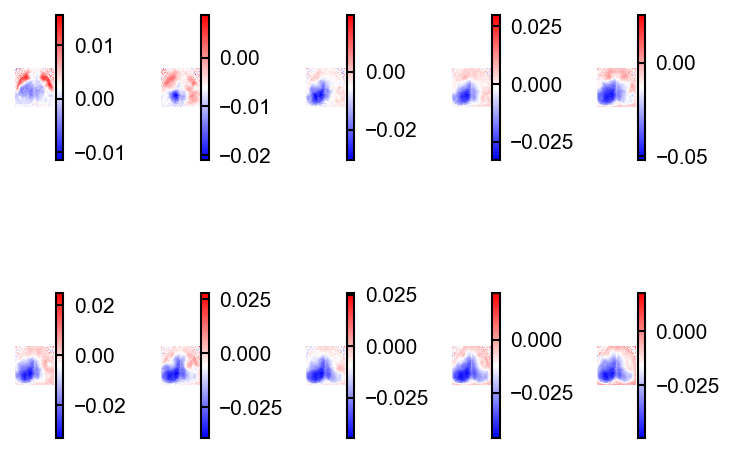

In [74]:
f=plt.figure(figsize=(5,5))
gs = mpl.gridspec.GridSpec(2,5)
for i in range(10):
    ax = plt.subplot(gs[i])
    plt.imshow(mean_ims_full[i].reshape(560,560),cmap='bwr')
    plt.colorbar()
    plt.axis('off')
    # plt.savefig(f'paperposterfigs/meanimg_{i}.pdf',dpi=300)

In [75]:
mean_ims_reshape = mean_ims.reshape(10,560,560)

In [76]:
mean_ims_reshape.shape

(10, 560, 560)

In [77]:
vids_th=[]
powers=[0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2]
pwscorr = [round(i/2.777777778,2) for i in powers]
for i, pw in enumerate(np.unique(pwscorr)):
    vid = mean_ims_full[i,:]
    booleanvids = vid <= thresholds[i]
    mean = np.mean(booleanvids,axis=0)
    vid = mean.reshape(560,560)

    vids_th.append(vid)

ValueError: cannot reshape array of size 1 into shape (560,560)

IndexError: list index out of range

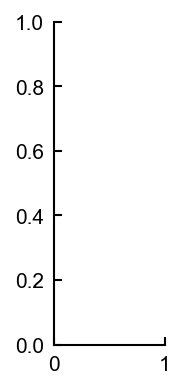

In [78]:
f=plt.figure(figsize=(5,5))
gs = mpl.gridspec.GridSpec(2,5)
for i in range(10):
    ax = plt.subplot(gs[i])
    plt.imshow(vids_th[i].reshape(560,560),cmap='bwr')
    plt.colorbar()
    plt.axis('off')
    # plt.savefig(f'paperposterfigs/meanimg_{i}.pdf',dpi=300)

In [ ]:
np.save('thresholded_vids.npy',vids_th) #10, 560, 560
np.save('unthresholded_vids',vids.reshape(10,560,560)) #10, 560,560
np.save('unthresholded_alltrials.npy',vids_notime) #10, 40, 560*560
np.save('vids_withtime.npy',vids_time) #10, 40, 560*560, 16

In [ ]:
fig=plt.figure(figsize=(3,1))
gs = mpl.gridspec.GridSpec(4,1)
pwscorr = [round(i/2.777777778,2) for i in powers]

first_ax=None
first_im=None

for i,pw in enumerate(np.unique(pwscorr)):
    vid = vids_avg[i,:]
    ax = plt.subplot(gs[i])
    vid = vid.reshape(560,560,-1)
    im = ax.imshow(vid, cmap='bwr', vmin=-0.1, vmax=0.1)
    ax.set_title(f'{pw} mW')
    ax.axis('off')

    if first_ax is None:
        first_ax = ax
        first_im = im

cbar = fig.colorbar(first_im, ax=first_ax, location='left')
cbar.set_label('Calcium activity (df/f)')
fig.savefig('paperposterfigs/imgs425spat1.pdf',dpi=300)


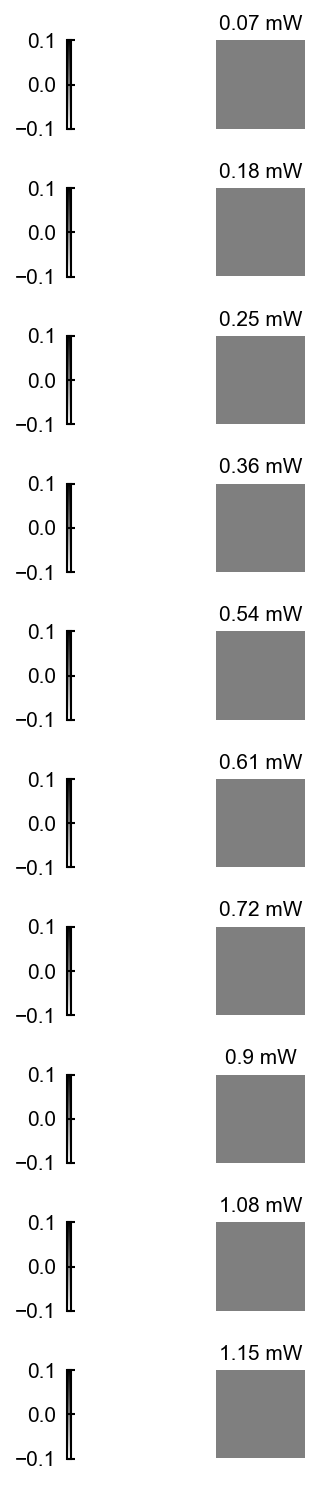

In [51]:
fig=plt.figure(figsize=(10,10))
gs = mpl.gridspec.GridSpec(10,1)

first_ax=None
# vids_notavg = np.array(vids_notavg)
for i,pw in enumerate(np.unique(pwscorr)):
    vid = vids_th[i,:,:]
    booleanvids = vid <= thresholds[i]
    # mean = np.mean(booleanvids,axis=0)
    # reshape_vid = mean.reshape(560,560,-1)

    ax = plt.subplot(gs[i])
    plt.imshow(booleanvids,cmap='gray_r')
    plt.axis('off')
    plt.colorbar(location='left')
    plt.title(f'{pw} mW')

    
    # if first_ax is None:
    #     first_ax = ax
    #     first_im = im

# cbar = fig.colorbar(first_im, ax=first_ax, location='left')
fig.savefig('paperposterfigs/thresholdedims425.pdf',dpi=300)